# Libraries

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pds
import scipy
import math
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from IPython.core.display import Image, display
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from plot_sklearn_dendrogram import plot_sklearn_dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas.plotting import parallel_coordinates
import graphviz 
from sklearn import tree
%matplotlib inline
np.random.seed(10)
random.seed(10)
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing # to scale data
from sklearn.metrics import silhouette_score
from pandas.plotting import parallel_coordinates

# Définition des fonctions

In [2]:
def confusion_matrix(c1,c2, alg1 , alg2, Labc1_def , Labc2_def, labc1 , labc2 ):
    """Retourne la matrice de contingence de deux clusterings c1 et c2."""
    if Labc1_def == True :
        Cla1 = c1.labels_
    else : 
        Cla1 = labc1
        
        
    if Labc2_def == True :
        Cla2 = c2.labels_
    else :
        Cla2 = labc2
 
    Cla1 = list(Cla1) 
    Cla2 = list(Cla2)
    for i in range(len(Cla1)):            
        if alg1 == 'km':
            Cla1[i] = 'km' + str(Cla1[i])
        elif alg1 == 'db':
            Cla1[i] = 'db' + str(Cla1[i])
        elif alg1 == 'cah':
            Cla1[i] = 'cah' + str(Cla1[i])
        else :
            return ('wrong name')
                
    for i in range(len(Cla2)):            
        if alg2 == 'km':
            Cla2[i] = 'km' + str(Cla2[i])
        elif alg2 == 'db':
            Cla2[i] = 'db' + str(Cla2[i])            
        elif alg2 == 'cah':
            Cla2[i] = 'cah' + str(Cla2[i])
        else :
            return ('wrong name')        
    
    Lab1 = map(str,sorted(set(Cla1)))
    Lab2 = map(str,sorted(set(Cla2)))
    allLabels = Lab1 + Lab2
    cm = metrics.confusion_matrix(Cla1, Cla2, labels=allLabels)
    cmdf = pds.DataFrame(data=cm, copy=True, index=allLabels, columns=allLabels).loc[Lab1, Lab2]
    cmdf = cmdf.transpose() # pour avoir les classeen ligne et les cluster en colonne (ou l'invese)
    
    return cmdf

In [77]:
def compute_stability(k,df,iterations=100):
    """For a given number of iterations, compute_stability calculs the silhouette cofficient associated to a Kmeans algorithme
    which runs with k clusters on the data frame named df. Computa_stability returns the standard deviation of the list of silhouette
    coefficients."""
    
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

In [4]:
def dendro_SSE (df, means_by_clusters):
    "df is a data frame containing a last column nammed 'clusters', calculated by hierarhical clustering "
    SSE =0
    for i in range(means_by_clusters.shape[0]):
        subset = df[df['clusters']==i]
        SSE+= sum((subset - means_by_clusters[i])**2)
    return SSE

In [5]:
def entropy_between_clusterings (cmdf , nc ):
    """This function allows to calcul the entropy. It could be use for classification, or two compare two clusterings. 
    It returns the entropy for each cluster and the max entropy."""
    proba = cmdf.values/cmdf.values.sum(axis=1, keepdims=True)
    entropy = [stats.entropy(row, base=2) for row in proba]
    max_entropy = math.log(nc,2)
    return entropy , max_entropy

In [6]:
def fancy_dendrogram(*args, **kwargs):
    '''This function allows to draw a dendrogram, with distances annoted inside the dendogram
      Function of Jörn's Blog :
      (https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)  '''
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [7]:
def kmeans_SSE(df,ax):
    """Plots SSE evolution for different clusters numbers (from 1 to 15) for a dataframe df."""
    sse = []
    Ks = range(1, 15)
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
        km.fit(df)
        #distance.append(np.sqrt(km.inertia_))
        sse.append(km.inertia_)
    ax.plot(Ks,sse)
    ax.set_xlabel("$k$",fontsize=20)
    ax.set_ylabel("SSE",fontsize=14)
    return sse

In [8]:
def kmeans_1D(attribute,n):
    """Prend en entrée un nparray et n clusters"""
    km1 = KMeans(n_clusters=n) # create a KMeans object
    km1.fit(attribute.reshape(-1,1))
    return km1

In [9]:
def plot_dendro_km(df,km):
    """Plots the dendrogram for a specified clustering km and a table df.
    Returns the Agglomerative clustering object."""
    DF_Dendro1 = df.copy(deep=True)
    agc = AgglomerativeClustering(n_clusters=len(km.cluster_centers_), affinity="euclidean", linkage="complete")
    agc.fit(DF_Dendro1)
    plt.title('Hierarchical Clustering Dendrogram')
    plot_sklearn_dendrogram(agc, labels=agc.labels_)
    plt.show()
    return agc

In [10]:
def plot_kmeans1D(attr,labels):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at = attr
    x_ind = range(0, len(at))
    plt.hist(at);

    plt.show()

In [11]:
# 3D plot using pyplot
def plot_km3d(km,df):
    """km est un objet de Kmeans. df est le dataframe correspondant sur lequel on a fait l'analyse."""
    fig = plt.figure() #opens a figure environment
    ax = Axes3D(fig) #to perform a 3D plot
    x=df.loc[:,'CO2']
    y=df.loc[:,'Population']
    z=df.loc[:,'Life_expectancy']
    ax.scatter(x, y, z,c=km.labels_.astype(np.float)) #plot definition and options 
    ax.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],km.cluster_centers_[:,2],c='r',s=100)
    # We set the colors to be in function of the labels of each cluster, ie each category
    # Cluster centers are in red
    ax.set_xlabel('CO2')
    ax.set_ylabel('Population')
    ax.set_zlabel('Life_expectancy')

In [12]:
def plot_pred_nbclusters(attr):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at =attr
    x_ind = range(0, len(at))
    plt.hist(at )
    plt.show()

In [13]:
def rand_sse(df, nb_clusters, obs_SSE):
    """This function allows to compare an observed SSEn computed with a Kmeans algorithm, to a random one obtained by permutation 
    of the data frame. It returns a plot, and the number time where the compute SSE is inferior to the random one. """
    SSE = []
    for i in range(500):
        dfv = df.values
        np.random.shuffle(dfv)
        
        km = KMeans(n_clusters= nb_clusters).fit(dfv)
        SSE.append(km.inertia_)
    sns.distplot(SSE)
    plt.axvline(obs_SSE, 0,7, c= "red")
    r = SSE < obs_SSE
    return r

In [14]:
def silhouette_kmeans(df,ax):
    """Plots Silhouette coefficient evolution for different values of k (clusters number)."""
    silhouette_coef = []
    Ks = range(2, 30)
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    ax.plot(Ks,silhouette_coef)
    ax.set_xlabel("$k$",fontsize=20)
    ax.set_ylabel("Silhouette Coef.",fontsize=14)

In [15]:
def silhouette_dbscan(df,minpts,min_knee):
    """Plots Silhouette coefficient evolution for different values of eps with a specified minpts parameter.
    Min_knee is the above limit value for eps.
    If one cluster (or only one cluster + noise points), silhouette arbitrary set to 0."""
    silhouette_coef = []
    Eps = np.arange(0.01,min_knee,0.01)
    for e in Eps:
        db = DBSCAN(min_samples=minpts,eps=e)
        db.fit(df)
        labels = db.labels_
        if len(set(labels))>2: 
            silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
        else:
            silhouette_coef.append(0)
    plt.plot(Eps,silhouette_coef)
    plt.xlabel("$eps$",fontsize=20)
    plt.ylabel("Silhouette Coef.",fontsize=14)



In [16]:
def stability_kmeans(df,ki):
    silhouette_coef = []
    sse = []
    k = ki
    n_init=1
    for i in range(100):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        sse.append(km.inertia_)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    ax1=plt.subplot(2, 2, 1)
    ax1.hist(sse)
    ax1.set_xlabel("SSE")
    ax2=plt.subplot(2, 2, 2)
    ax2.hist(silhouette_coef)
    ax2.set_xlabel("Silhouette")
    plt.show()

In [17]:
def plot_stability(df):
    stability = []
    Ks = range(2,30)
    for k in Ks:
        stability.append(compute_stability(k,df))
    plt.plot(Ks,stability,"o-")
    plt.xlabel("$k$",fontsize=20)
    plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")
    plt.show()
    

# Introduction 

Ce second Notebook est dans la continuité du premier. Dans le premier, Projet_IA_Clustering_simple, nous avions mis en place une stratégie pour l'analyse des données grâce à des techniques de  clustering ( recherche des outliers, choix du nombre de clusters, évaluation de la qualité du clustering...). Dans cette seconde partie, nous allons reprendre cette stratégie sur des données en plus grande dimension.

# Importation des données

## Définition des variables 

In [18]:
df_global = pds.read_csv('./Data2/Data2.txt', sep="\t") # load a pandas dataframe from csv
df_global.head()

,Time,Time Code,Country Name,Country Code,Children out of school,CO2 emissions (kt),Non-renewable lectricity production (% of total),Renewable electricity production excluding hydroelectric (% of total),Life expectancy (years),Population,Rural population,Urban population,Surface area (sq. km)
0,2013,YR2013,Afghanistan,AFG,NaN,10014.577,NaN,NaN,62.494,31731688.0,23997724.0,7733964.0,652860.0
1,2013,YR2013,Albania,ALB,10957.0,5064.127,0.00000,0.0,77.702,2895092.0,1291587.0,1603505.0,28750.0
2,2013,YR2013,Algeria,DZA,NaN,134465.223,99.44899,0.0,75.418,38338562.0,11664124.0,26674438.0,2381740.0
3,2013,YR2013,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,55307.0,6997.0,48310.0,200.0
4,2013,YR2013,Andorra,AND,NaN,476.710,NaN,NaN,NaN,80788.0,9261.0,71527.0,470.0


In [19]:
df_gdp = pds.read_csv('./Data_Classif/Data.txt', sep="\t")

On choisit de construire les attributs dérivés suivants : 
* CO2/habitant
* PIB/habitant d'âge moyen
* population unbaine/population totale 

En effet, on veut décrire le lien entre les variables à ressources égales (en considérant que les ressources correspondent au nombre  d'habitants).

On a choisi ces attributs qui n'ont pas de lien direct entre eux, même si on peut s'attendre à une corrélation relative entre le taux de CO2 par habitant et la population urbaine.

In [20]:
df = pds.DataFrame()
df ['Life_expectancy'] = df_global['Life expectancy (years)']
df ['CO2_hab']  = df_global['CO2 emissions (kt)']/df_global['Population']
df ['GDP_hab'] =df_gdp['GDP'] 
df ['Prop_urb'] = df_global['Urban population']/df_global['Population']
df ['Country '] = df_global['Country Name']
df.head() 

,Life_expectancy,CO2_hab,GDP_hab,Prop_urb,Country
0,62.494,0.000316,638.612543,0.243730,Afghanistan
1,77.702,0.001749,4413.081697,0.553870,Albania
2,75.418,0.003507,5471.123389,0.695760,Algeria
3,NaN,NaN,11589.853002,0.873488,American Samoa
4,NaN,0.005901,40619.711298,0.885367,Andorra


## Nettoyage des lignes

Supression des lignes contenant des valeurs manquantes

In [21]:
filtered_df = df.dropna(subset=['Life_expectancy', 'CO2_hab','GDP_hab', 'Prop_urb'])

## Sélection des données à analyser

In [22]:
df_clustering=filtered_df[['Life_expectancy', 'CO2_hab','GDP_hab', 'Prop_urb']]

## Normalisation des données

On centre et on réduit les odnnées car elles ne sont pas exprimées dans la même unité, de plus elles ont des ordres de grandeurs très différents.

### Centrage

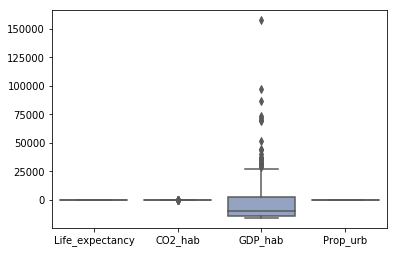

In [23]:
ax=sns.boxplot(data=(df_clustering - df_clustering.mean()), orient="v", palette="Set2")

Nous devons également réduire en raison de la variance élevée du PIB par habitant d'âge moyen.

### Réduction 

(-2, 2)

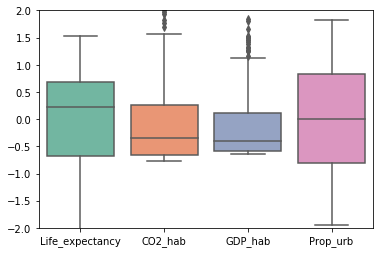

In [24]:
ax=sns.boxplot(data=(( df_clustering - df_clustering.mean() )/df_clustering.std()), orient="v", palette="Set2")
ax.set_ylim(-2,2)

Ce sont les données finales sur lesquelles on va travailler.

In [25]:
df_clustering_norm=(df_clustering - df_clustering.mean())/df_clustering.std()

# Recherche des outliers

Comme précédemment nous allons rechercher les outliers grâce à DBSCAN. La première étape est donc de paramétriser cet algorithme en traçant la distance de chaque point à son 4$^{ème}$ voisin le plus proche, grâce à l'algorithme des KNN.

## Définition des paramètres de DBSCAN

In [26]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(df_clustering_norm)
distances, indices = nbrs.kneighbors(df_clustering_norm)
distances_to_4 = distances[:,3]
distances_to_4 = sorted(distances_to_4 , reverse = False)

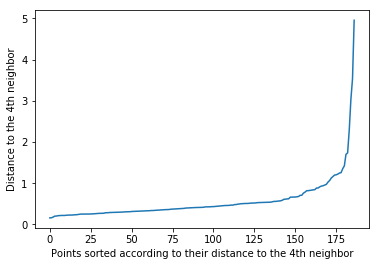

In [27]:
Index = range(0,len(distances_to_4))
plt.plot(Index , distances_to_4)
plt.xlabel('Points sorted according to their distance to the 4th neighbor')
t=plt.ylabel('Distance to the 4th neighbor')

D'après le graphique ci-dessus on observe un coude pour les pays indexés entre 165 et 175. On calcul la distance moyenne au 4$^{ème}$ voisin dans cet intervalle afin d'initialiser de DBSCAN.

In [28]:
mean_dist_knee = sum(distances_to_4[165:175])/10
mean_dist_knee

1.0277527177785248

On considérera donc un rayon de recherche d'environs 1.027, et  au moins trois points pour la construction d'un cluster.

## Annalyse des résultats de DBSCAN

In [29]:
outliers_det = DBSCAN(min_samples=3,eps=mean_dist_knee).fit(df_clustering_norm)
# Number of outliers
sum(outliers_det.labels_ == -1) 

11

D'après le rayon définit ci-dessus DBSCAN exclut 11 pays considérés comme outliers.

In [30]:
df_clustering_norm_lab= df_clustering_norm.copy(deep=True) # Copy of DF_kmeans1
df_clustering_norm_lab['Labels'] = outliers_det.labels_

# Représentation de DBSCAN

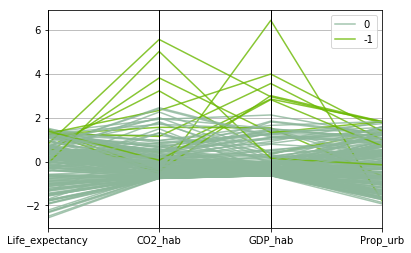

In [31]:
parallel_coordinates(df_clustering_norm_lab,'Labels', alpha=0.8)
plt.show()

In [54]:
df_clustering_countries= df_clustering_norm_lab.copy(deep=True) # Copy of DF_kmeans1
df_clustering_countries['Country'] = filtered_df.iloc[:, 4] 
print(df_clustering_countries[(df_clustering_countries['Labels'] == -1)]).iloc[:,-1] 


14                 Bahrain
21                 Bermuda
65           Faroe Islands
106                 Kuwait
114          Liechtenstein
116             Luxembourg
117       Macao SAR, China
147                 Norway
159                  Qatar
188            Switzerland
196    Trinidad and Tobago
Name: Country, dtype: object


DBSCAN exclut le Lichetenstein, l'australie et Quatar ou encore le Bermuda à cause de leur fort PIB par habitant. Le Quatar, le Bahrain   ou encore la République de Trinite et Tobago sont exclus à cause de leur fort taux d'émissin de CO2 par habitant. 

In [73]:
df_without_outliers=df_clustering_norm_lab[df_clustering_norm_lab.Labels != -1]
df_without_outliers=df_without_outliers.drop('Labels',axis=1)

# Clustering

##  Détermination des centroïdes initiaux à l'aide d'un clustering hiérarchique
Le clustering hiérarchique calculé ci-dessous aura pour but d'initialiser les centroïdes des Kmeans. Il est calculé grâce à la méthode'max'. Ainsi la similatrité entre deux clusters est définie à partir des deux éléments les plus distants. 

In [56]:
acwo = AgglomerativeClustering(affinity="euclidean", linkage="complete",n_clusters=5)
acwo.fit(df_without_outliers)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=5, pooling_func='deprecated')

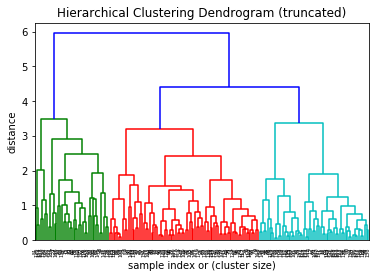

In [57]:
Z = linkage(df_without_outliers, 'complete')
# Z is a linkage matrix where distances are calculated owing complete method which is also named max
dn = dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

On remarque un écart important entre les cluster pour une distance de 3.2, nous nous servirons de cette distance pour construir cinq clusters.

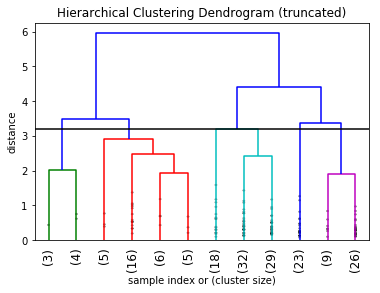

In [59]:
max_d = 3.2
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [60]:
clusters = fcluster(Z, max_d, criterion='distance')
df_without_outliers_dendro_cluster = df_without_outliers.copy()
df_without_outliers_dendro_cluster['clusters'] = clusters

In [105]:
cluster_dendro_tab = pds.crosstab(index=df_without_outliers_dendro_cluster['clusters'],  columns="count") 
#cluster_dendro_tab

on remarque que les groupes sont assez  déséquilibrés, le cluster 1 est cmomposé de 7 pays et le cluster 3 de 79 pays.

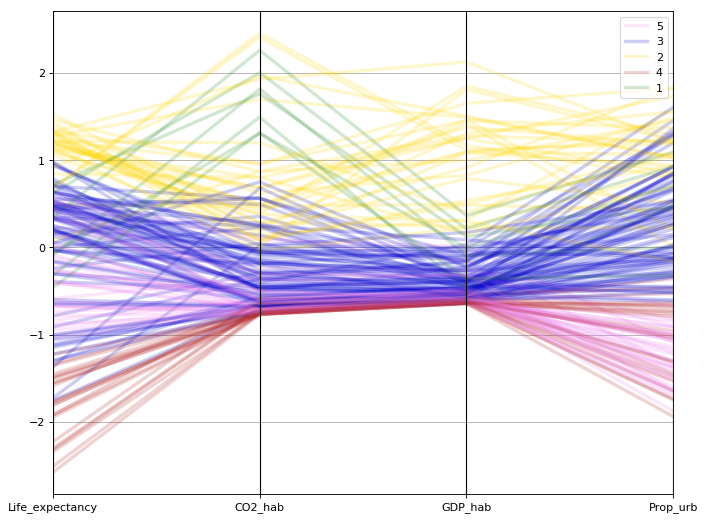

In [135]:
# NE PAS COMPILER !!!!!!
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
parallel_coordinates(df_without_outliers_dendro_cluster,'clusters', alpha=0.2,  color=('violet' , 'mediumblue', 'gold', 'firebrick', 'forestgreen') , linewidth = 3)
plt.show()

In [62]:
df_wo_dendro_cluster_country=df_without_outliers_dendro_cluster.copy()
df_wo_dendro_cluster_country['Country'] = filtered_df.iloc[:, 4] 
Subset_df_wo_dendro_cluster_country =df_wo_dendro_cluster_country.iloc[:,4:]
#Subset_df_wo_dendro_cluster_country[Subset_df_wo_dendro_cluster_country['clusters'] == 2]

* Le clusters 4 (rouge) rassemble les pays pays ayant la plus faible espérance de vie. On retrouve ainsi des pays comme le Burkina Faso, la Somalie ou encore la Zambie.
* Le clusterss 5 (rose), second groupe des pays les plus pauvres, rassemble des pays avec une espérance plus forte que celle des pays du cluster 4, leur taux d'émission de CO2 ainsi que leur GDP par habitant sont également plus élevés. Ces pays ont toutefois un taux d'urbanisation comparable aux pays du cluster 4. 
* Le cluster 1 (vert) rassemble les pays qui ont un fort taux d'émission de CO2 par habitant. On retrouve ainsi les pays producteurs de pétrole comme Arabie Saoudite ou l'Oman,  les pays producteurs de gaz comme la Russie, ou encore les pays dont la principale ressource d'énergie est le Charbon comme l'Estonie.
* Le cluster 2 (orange) rassemble les pays riches qui sont généralement de forts émetteurs de CO2. On retroue les pays de l'Europe Occidentale, le Canada ou encore l'Australie.
* Finalement le cluster 3 (bleu) rassemble les pays que nous pourrions qualifier de médians. 

In [63]:
means = df_without_outliers_dendro_cluster.groupby('clusters').mean()
Means =np.array(means)

## Kmeans

Pour définir le nombre de clusters optimal, on se base sur la SSE et le coefficient Silhouette.

SSE est un indice de la qualité du clustering. Il permet de mesurer à quel point les objets sont liés à leur cluster. En effet la SSE est somme des carrés des écarts entre chaque point et le centroïde de son cluster.

Le coefficient silhouette et également un indice de la qualité du clustering; il apporte d'avantage d'informations par rapport à la SSE. En effet il traduit d'une part le degré d'apartenance des objets à leur cluster (en calculant la distance moyenne de chaque point aux différents points de son cluster), et d'autre part la séparation des clusters. Un coefficient silhouette élevé indique que le clustering est de bonne qualité.

On utlisera ces indices pour déterminer le nombre de clusters.

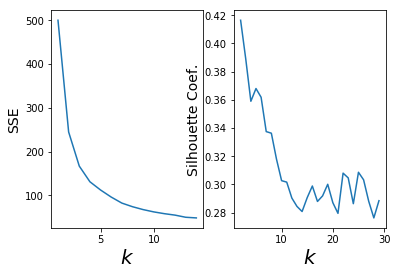

In [64]:
fig=plt.figure()
ax = fig.add_subplot(121)
sse=kmeans_SSE(df_without_outliers,ax)
ax = fig.add_subplot(122)
sil=silhouette_kmeans(df_without_outliers,ax)

La SSE suggère entre 2 et 5 clusters et le coefficient silhouette moins de 10 cluster. Après expérimentation on conservera 5 clusters.

###  Premier Kmeans avec des centroïdes initiaux aléatoires

In [65]:
km=KMeans(n_clusters=5).fit(df_without_outliers)

###  Second Kmeans avec des centroïdes  initiaux du clustering hiérarchique

Initialisation des centroides grâce au clustering hiérarchique avec 5 clusters : permet de ne pas répéter KMeans

In [66]:
kmdendro_max = KMeans(n_clusters=5, init = Means).fit(df_without_outliers)

/Users/mathian/miniconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [68]:
print('Centroïdes avec des centroïdes  initiaux du clustering hiérarchique')
print(kmdendro_max.cluster_centers_)

print('Centroïdes   avec des centroïdes initiaux aléatoirese')
print(km.cluster_centers_)

Centroïdes avec des centroïdes  initiaux du clustering hiérarchique
[[ 0.23392649  1.87038876  0.22840871  0.5943711 ]
 [ 1.16711247  0.64723239  1.09588661  1.10369852]
 [ 0.34097988 -0.16776902 -0.31826001  0.43256317]
 [-1.60665918 -0.65612101 -0.57714597 -0.75681365]
 [-0.21763004 -0.56413201 -0.51869444 -1.09443292]]
Centroïdes   avec des centroïdes initiaux aléatoirese
[[ 0.38307125 -0.16401372 -0.31606504  0.41426215]
 [ 1.16711247  0.64723239  1.09588661  1.10369852]
 [-0.2875929  -0.57501209 -0.52675902 -1.13737233]
 [ 0.23392649  1.87038876  0.22840871  0.5943711 ]
 [-1.61779031 -0.64060261 -0.56700692 -0.61888872]]


On retrouve des centroides quasi équivalents, on ne représentera donc qu'un seul des deux résultats.

In [69]:
df_km_lab=df_without_outliers.copy()
df_km_lab['Labels']=kmdendro_max.labels_

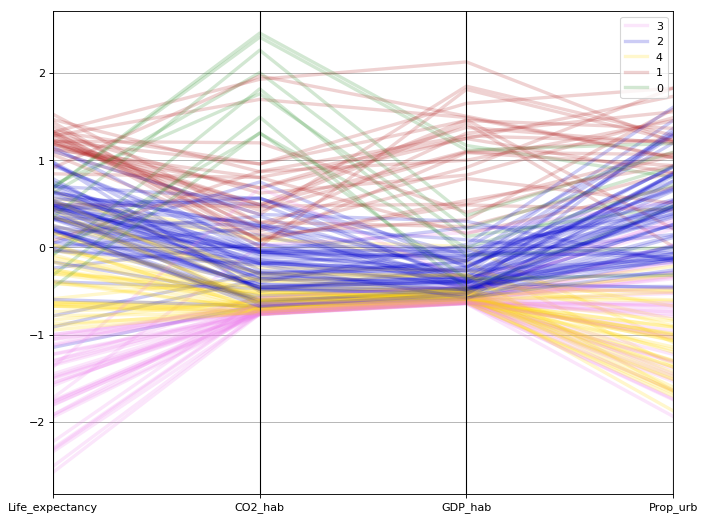

In [77]:
# NE PAS COMPILER !!! (Sinon les commentaire doivent être modifié, nom des clluster et couleur en particulier !)
fig=plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='k')
parallel_coordinates(df_km_lab,'Labels', alpha=0.2,  color=('violet' , 'mediumblue', 'gold', 'firebrick', 'forestgreen') , linewidth = 3)
plt.show()

La variable la mieux expliquée par ce clustering est l'espérance de vie, l'interprétation des autres variables est moins évidente étant donné le chevauchement des groupes.

In [71]:
df_km_lab_country=df_km_lab.copy()
df_km_lab_country['Country'] = filtered_df.iloc[:, 4] 
Subset_df_km_lab_country =df_km_lab_country .iloc[:,4:]
#Subset_df_km_lab_country[Subset_df_km_lab_country['Labels'] == 3]

* Le cluster 3 (rose) rasemble les pays ayant la plus faible espérance de vie. Ce groupe rassemble les pays les plus pauvre comme la Somalie, l'Ouganda ou les pays guerre comme le Chad, et le sud Soudan. 
* Le cluster 4 (jaune) regroupe des pays ayant  une espérance de vie  plus grande que les pays du cluster 3. Ce cluster rassemble des pays avec un PIB par habitant légerement plus élevé. Remarquons que le cluster 3 et 4 ont le profil au niveau du taux d'urbanisation.
* Les pays du cluster 2 (bleu) ont une meilleure espérance de vie que les pays des clusters 3 et 4, leur taux urbanisation est relativement important comparé à celui des pays des cluster 3 et 4. Le cluster 2 regroupe des pays plus 'divers'. On retrouve nottament des pays très industrialisé comme l'Inde, le Bungladesh, ou encore le Vietman, mais aussi des pays d'Europe comme le Portugal, la Pologne ou la Roumanie.
* Les pays du cluster 0 (vert) ont en moyenne meilleure espérance de vie équivalente aux pays du cluster 2. Ces pays ont un taux d'urbaniation important. Leur taux d'émission de CO2 par habitant très élevé. Ce cluster rassemble en effet les pays producteurs de pétrole comme les Emirats Arabe Unis, l'Arabie Soudite ou la Turquie.
* Enfin le cluster 1 (rouge) rassemble les pays riches qui ont une forte espérance de vie, un fort taux d'urbanisation, et un PIB par habitant élévé. Ces pays qui émetttent généralement le moins de CO2 par habitant que les pays producteurs de pétrole. On retrouve au sein de ce cluster la France , l'Angleterre, l'Allemagne ou encore le Japon, et les USA.

### Analyse de stabilité de Kmeans

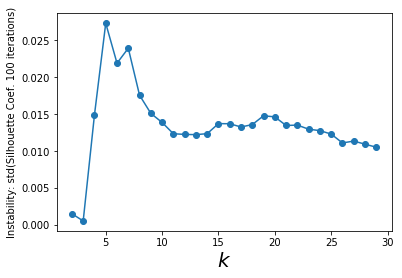

In [78]:
plot_stability(df_without_outliers)

Le coefficient Silhouette varie beaucoup autour des cinq clusters choisis : donc les clusters trouvés sont souvent différents.

## Evaluation de la qualité du Clustering par la SSE

/Users/mathian/miniconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


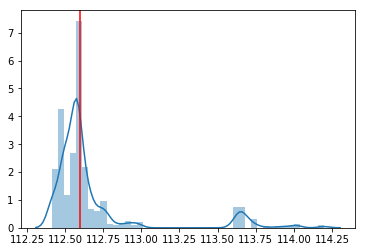

In [79]:
r = rand_sse(df_without_outliers,  5,kmdendro_max.inertia_ )

In [80]:
print(kmdendro_max.inertia_)
print('Number of cases where SSE is inferior to the SSE that we observed ' ,sum(r))

112.5957065242716
('Number of cases where SSE is inferior to the SSE that we observed ', 346)


Dans 129 cas sur 500 on obtient avec des donées aléatoires une SSE inférieure à celle obtenue avec notre jeu de données. Donc la probabilité d'observer par hasard une SSE de  inférieure à celle obtenue sur nos données  (112.16) est de 25.8%. La validité de ce clustering ainsi que la structure des données peuvent être discutées.

## DBSCAN

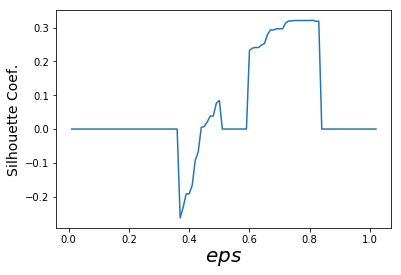

In [81]:
minpts=10
silhouette_dbscan(df_without_outliers,minpts,mean_dist_knee)

Le coefficient silhouette est maximisé pour un rayon autour de 0.7.

In [82]:
db=DBSCAN(min_samples=3,eps=.7).fit(df_without_outliers)

In [83]:
# Add DBSCAN's results to our data frame
df_db_lab=df_without_outliers.copy(deep=True)
df_db_lab['Labels']=db.labels_

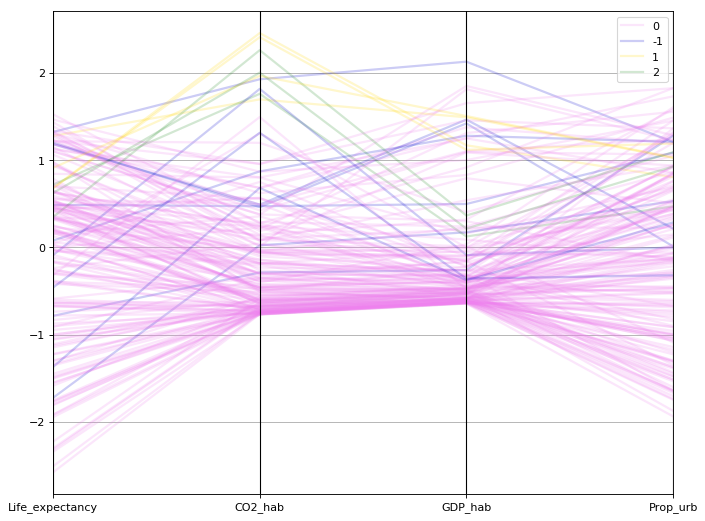

In [67]:
# NE PAS COMPILER !!! (Sinon les commentaire doivent être modifié, nom des clluster et couleur en particulier !)
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
parallel_coordinates(df_db_lab,'Labels', alpha=0.2,  color=('violet' , 'mediumblue', 'gold', 'forestgreen'), linewidth=2 )
plt.show()

In [84]:
# Add country to our data frame
df_db_lab_country=df_db_lab.copy()
df_db_lab_country['Country'] = filtered_df.iloc[:, 4] 
Subset_df_db_lab_country =df_db_lab_country .iloc[:,4:]
#Subset_df_db_lab_country[Subset_df_db_lab_country['Labels'] == -1]
#df_db_lab_country[df_db_lab_country['Country']=='Ireland']

DBSCAN propose des résultats très différents des Kmeans ou du dendrogramme. En effet rappelons que cet algorithme est fondé la densité des données. 
* Le cluster 0 (rose) inclut la quasi totalité des 184 pays avec 159 pays.
* Le cluster 2 (vert) regroupe les pays dont le taux d'émission de CO2 par habitant est très élevé. On retrouve ainsi l'Arabie Saoudite et Oman qui sont deux grands producteurs de pétrole. On retrouve également Estonie car elle utilise le Charbon comme principale source d'énergie.  
* Le cluster 1 (jaune) rassemble les pays très pollueurs, mais pour lesquels le PIB par habitant est plus élevé que pour les pays du cluster 2. On retrouve ainsi les pays 'riches' comme les USA, le Canada ou encore les Emirats Arabe Unis. 
* Le cluster -1 (bleu) est le groupe des outliers, c'est à dire l'ensemble des pays pour lesquels la combinaison des variables observés est inattendue . On retrouve par exemple l'Afrique du Sud qui a une espérance de vie très faible mais un taux d'émission de CO2 relativement fort.

## Enveloppe des clusters

###  Enveloppe des clusters pour les Kmeans 

In [85]:
classes=df_km_lab['Labels']
features=df_km_lab.drop('Labels',axis=1)
#Tree_LE =Tree_LE.drop('Life_expectancy',axis=1)

km_tree  = DecisionTreeClassifier(criterion = 'entropy', random_state=0 ) # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
clf = km_tree.fit(features,classes)

sortedLabelList = sorted(list(set((classes))))
for i in sortedLabelList :
    sortedLabelList[i]= str(sortedLabelList[i])
sortedLabelList

['0', '1', '2', '3', '4']

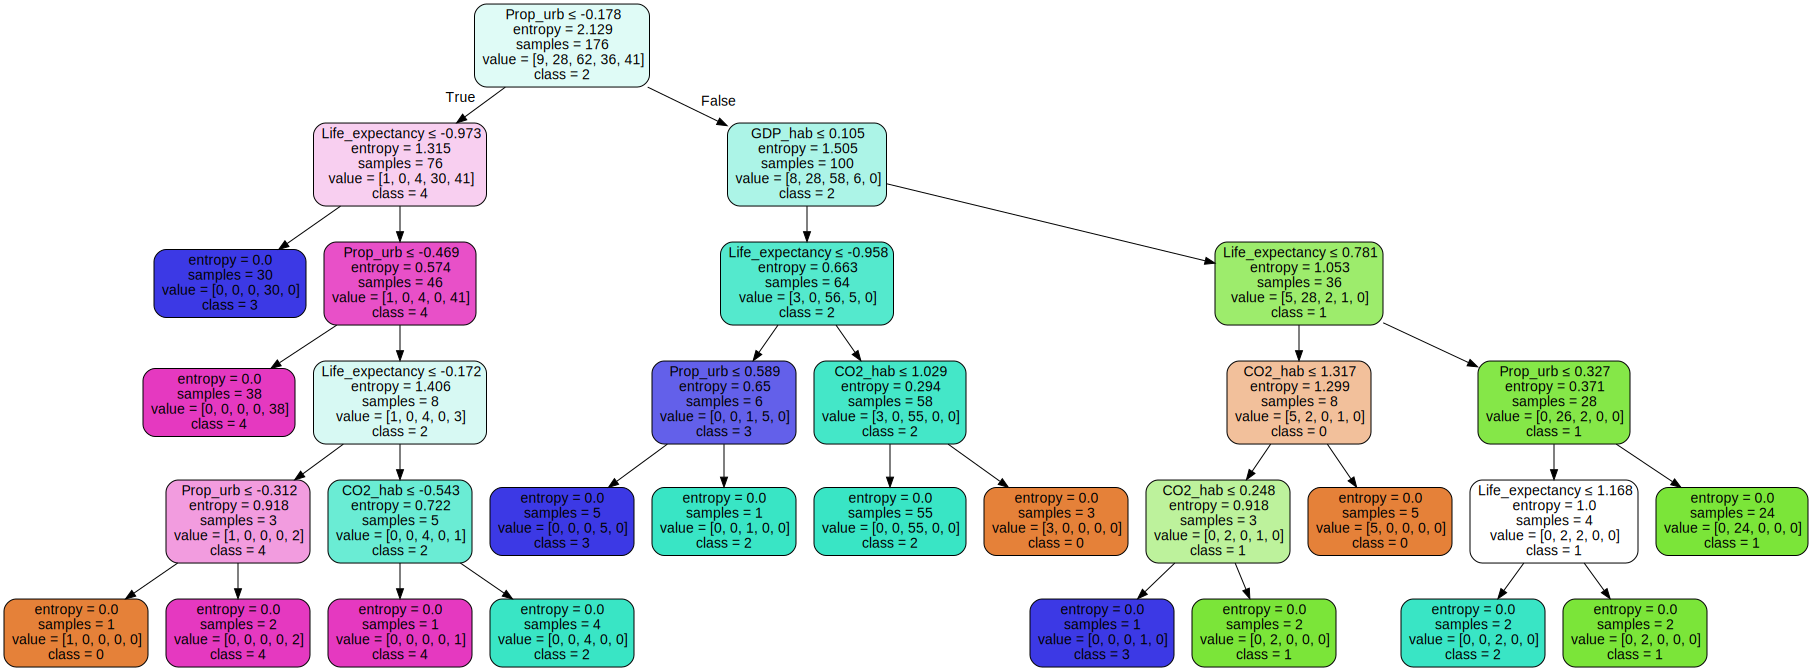

In [86]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features.columns,  
                         class_names=sortedLabelList,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

L'arbre semble à première vue très complexe mais en interprétant uniquement les grands regroupements nous pouvons analyser les caractéristiques de chaque clusters.
* Les clusters 3 et 4 ont taux d'urbanisation faible comparément à celui des autres clusters. La seconde variable permettant de séparer les cluster 3 et 4 est l'espérance de vie. Grâce à cette  deuxième règles on regroupe 30 pays parmi 36 appartenant au groupe 3, qui sont les pays ayant une espérance de vie très faible, et 38 pays parmis 41 appartenant au groupe 4.
* Parmi les trois groupes restant, le PIB par habitant permet de séparer les pays du cluster 1 (riches) des pays des clusters  0 et 2. Ensuite l'espérance de vie et le taux d'émission de CO2 permettent de séparer les pays producteurs d'énergie fossile (cluster 0), des pays du cluster 2 qui ont un taux d'émission de CO2 par habitant plus faible. Finalement au sein de cette branche le cluster 2 peut qualifié de cluster moyen.

### Enveloppe des clusters de DBSCAN

['-1', '0', '1', '2']


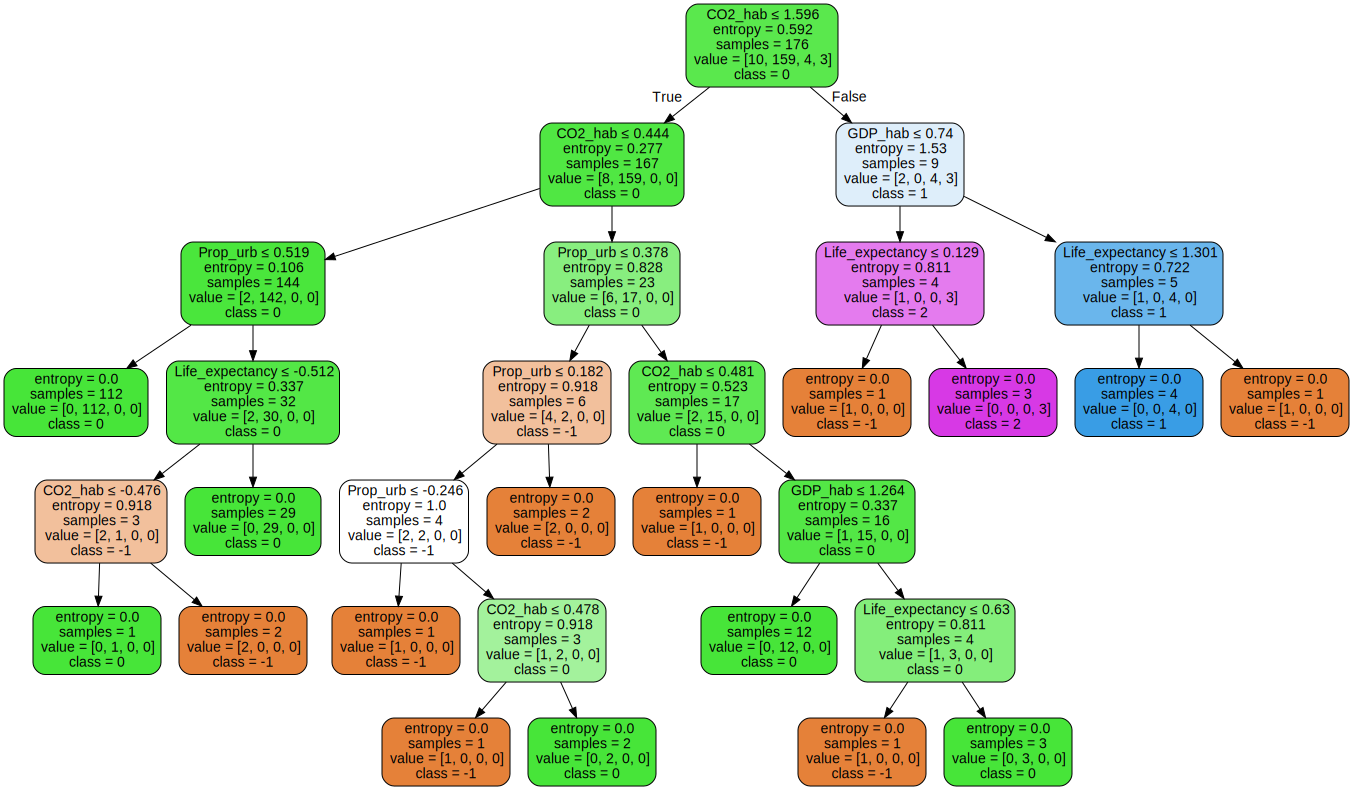

In [87]:
classes_db=df_db_lab['Labels']
features_db=df_db_lab.drop('Labels',axis=1)
db_tree  = DecisionTreeClassifier(criterion = 'entropy', random_state = 0) # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
clf_db = db_tree.fit(features_db,classes_db)

sortedLabelList_db = sorted(list(set((classes_db))))
for i in range(len(sortedLabelList_db)) :
    sortedLabelList_db[i]= str(sortedLabelList_db[i])
print(sortedLabelList_db)


dot_data = tree.export_graphviz(clf_db, out_file=None, 
                         feature_names=features.columns,  
                         class_names=sortedLabelList_db,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph



* Les pays des clusters 1 (USA, Canada, Japon) et 2 (Arabie Saoudite, Estonie, Oman ) sont différenciés des autres clusters à cause de leur fort taux d'émission de CO2. Pour séparer ces deux groupes, l'espérance de vie par habitant est utilisée, étant donné que les pays du cluster 1 ont une espérance de vie plus élevée que ceux du cluster 2.
* Les pays du cluster -1 sont difficilement caractérisables. Ce groupe rassemble des pays pour lesquels la combinaison des variables observées n'est pas usuelle.
* Le cluster 0 rassemble les pays restant, soit la majorité 159/177 pays. C'est donc l'ensemble des pays qui n'ont pas de valeurs extrêmes en termes d'émission de CO2 par habitant, et ceux qui n'ont pas une combinaison inusuelle des variables observées.

### Enveloppe des clusters du clustering hiérarchique

['1', '2', '3', '4', '5']


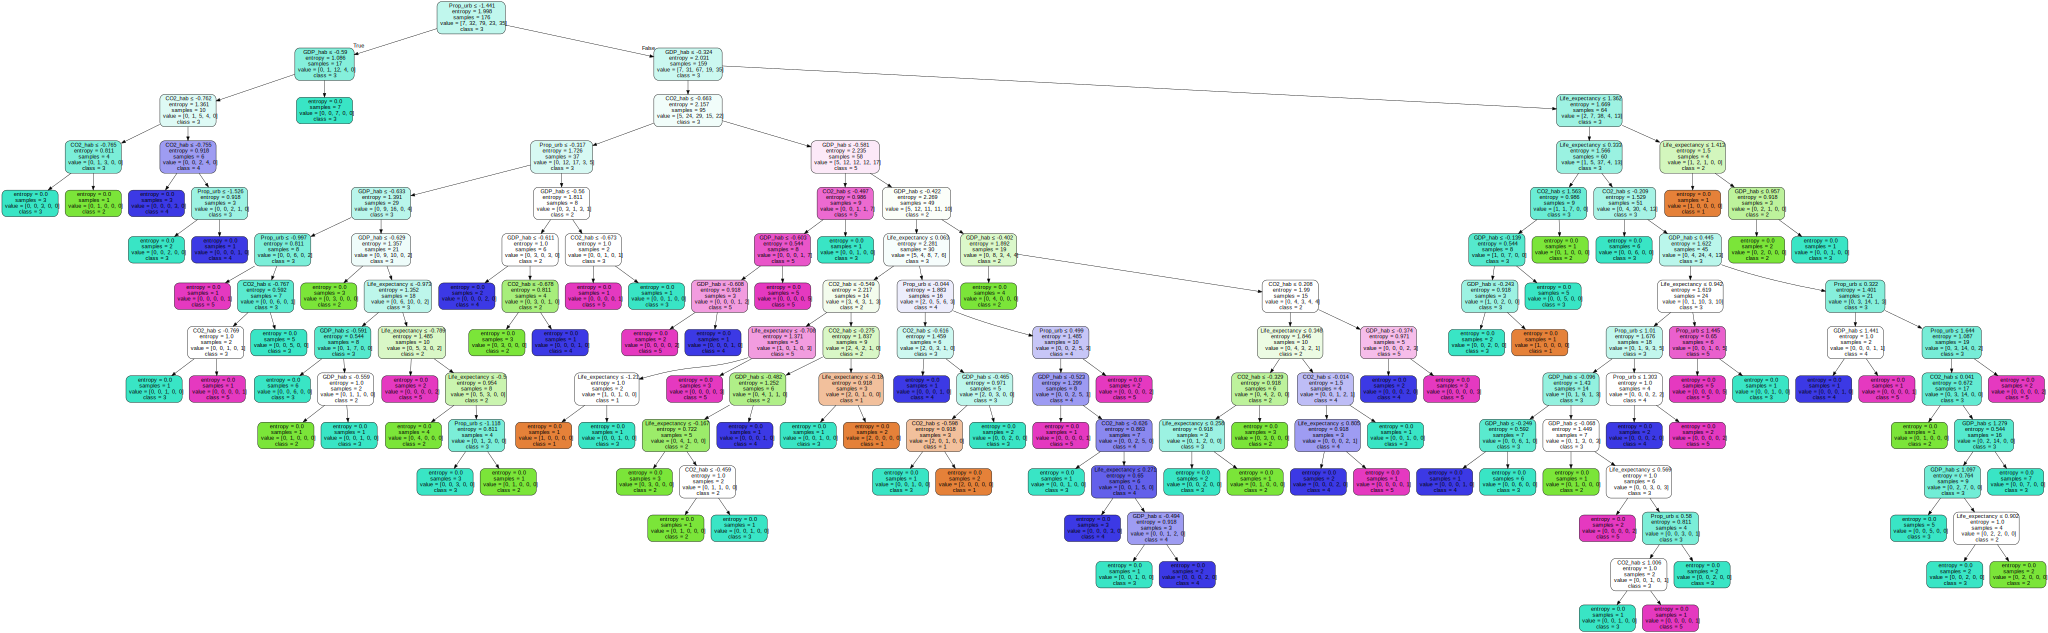

In [89]:
classes_dendro=df_without_outliers_dendro_cluster['clusters']
features_dendro=df_without_outliers_dendro_cluster.drop('clusters',axis=1)
dendro_tree  = DecisionTreeClassifier(criterion = 'entropy',  random_state=0) # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
clf_dendro = dendro_tree.fit(features_db,classes_dendro)

sortedLabelList_dendro = sorted(list(set((classes_dendro))))
for i in range(len(sortedLabelList_dendro)) :
    sortedLabelList_dendro[i]= str(sortedLabelList_dendro[i])
print(sortedLabelList_dendro)


dot_data = tree.export_graphviz(clf_dendro, out_file=None, 
                         feature_names=features.columns,  
                         class_names=sortedLabelList_dendro,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph


L'arbre de décision n'est pas interprétable, en effet le modèle construit est extrêment complexe.  Il est donc difficile d'observer des règles de décion  premettant de caractériser les différents clusters. Néanmoins d'après le graphique 'parallel_coordinates' les groupes construits grâce à cet algorithme semblent correspondre à ceux établis avec les Kmeans, pour vérifier cet observation nous allons construire une table de contingence.

# Comparaison des clusters

## Matrices de contingences

### Création des matrices de contingences

In [90]:
cm_kmdb=confusion_matrix(km,db, 'km', 'db', True , True , 'None', 'None')
cm_kmac=confusion_matrix(km,acwo, 'km', 'cah', False , False ,df_km_lab_country['Labels'],df_without_outliers_dendro_cluster['clusters'] )
cm_dbac=confusion_matrix(db,acwo, 'db', 'cah', True  , False , 'None' , df_without_outliers_dendro_cluster['clusters'])
cm_acdb=confusion_matrix(acwo, db,'cah', 'db', False ,  True  , df_without_outliers_dendro_cluster['clusters'], 'None' )

### Comparaison des Kmeans et de DBSCAN

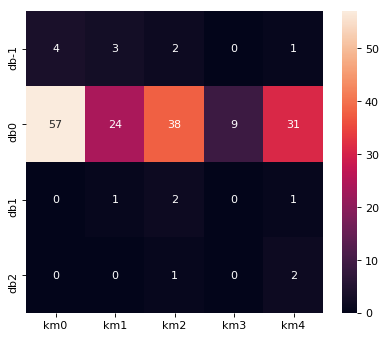

In [140]:
fig=plt.figure(figsize=(6, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(cm_kmdb, annot=True)

Comme la cluster 0 de DBCSAN rassemble les 'core points', donc la majorité des pays, ce clulster est celui qui  contribue le plus à tous les clusters définis par Kmeans. Kmeans ne différenciant pas les cluters de "border points"(db1 , db2) et les clusters de "noise points"(db-1), ces groupes sont donc également réparties dans tous les clusters formés par les Kmeans.


**Conclusion : les méthodes de clustering DBSCAN et de Kmeans sont très différentes, et aboutissent donc à une interprétation différente du jeu données.**

### Comparaison du clustering hiérarchique et  de Kmeans 

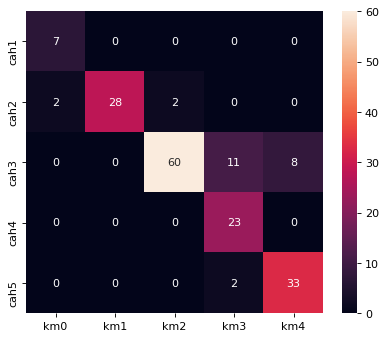

In [141]:
fig=plt.figure(figsize=(6, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(cm_kmac, annot=True)

Les groupes formés par le clustering hiérarchique sont similaires à ceux calculés par les Kmeans.

* Le cluster 0  des Kmeans qui regroupe les pays ayant un fort taux d'émission de CO2 par habitant, il est très bien  représenté par le cluster 1 du clustering hiérarchique. On retrouve toutefois 2 pays du cluster 0 des Kmeans qui appartiennent au cluster 2 du dendrogramme cluster des pays riches et pollueurs.

* Les 28 pays riches  regroupés dans le cluster 1 de Kmeans sont inclus dans le  cluster 2 du clustering hiérarchique. Les deux algorithmes ont donc identifié quasiment le même groupe de pays riches. Cependant 4 pays qui appartiennent au cluster 2 du dendrogramme  mais sont associés au cluster 0 soit au cluster 2 des Kmeans.

* Le cluster 3 de Kmeans, correspondant au pays les plus pauvres, est partagé entre les clusters 3 et 4 du dendrgogramme qui peuvent être assimilés au groupe médian et récirpoquement au groupe des pays les plus pauvres.

* Le cluster 4 des Kmeans, correspondant au second groupe des pays les plus pauvres, est essentiellement expliqué grâce au cluster 5 du dendrogramme. Cependant le clustering hiérarchique considère que parmi les 42 pays du clusters 4 des Kmeans 8 appartiennent au groupe 'médian' (i.e cluster 3 du dendrogramme). 


* Le cluster 2 des Kmeans, cluster des pays médians, est bien représenté par le cluster 3 du dendrogramme. Soulignons que le groupe 'médian' défini par le dendrogramme (cah3) est plus large que celui défini par les kmeans étant donné que celui-ci inclut une partie des deux cluster des pays pauvres (km3 et km4).

**Conclusion : Malgré quelques différences entre les groupes formés par les deux algorithmes, l'interprétation générale de ces deux clusterings est identique.**

###   Comparaison du clustering hiérarchique et de DBSCAN

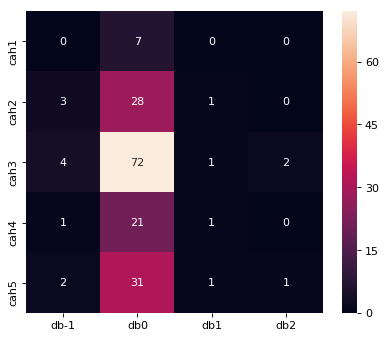

In [145]:
fig=plt.figure(figsize=(6, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(cm_dbac, annot=True)

À l'instar de la comparaison effectuée entre les Kmeans et DBSCAN, l'ensemble des pays sont esssentiellement regroupés dans le cluster 0 de DBSCAN, il  inclut ainsi des pays appartenant aux différents groupes formés par le clustering hiérarchique.  

## Comparaison des clusterings grâce à l'entropie

Pour comparer la qualité de deux clusterings nous pouvons évaluer l'entropie. En effet si on considère que  les solutions d'une première méthode de clustering (colonne 'Labels' ou 'Clusters') permettent de définir $n$ classes de références alors nous pouvons évaluer pour tous pays X appartenant au $i^{ème}$ cluster de la seconde méthode de clustering, la probabilité que X appartiennent à chacun des $n$ clusters definis par la première méthode connaissant la composition $i^{ème}$ cluster .  Ainsi l'entropie du $i^{ème}$ cluster est calculée telle que : $$E(X)=\sum_{a=1}^{n} P(X=a)*log(P(X=a))$$
Une entropie faible traduit la pureté du cluster $i$.

### Comparaison de l'entropie entre Kmeans et DBSCAN

On utilise les résultats de Kmeans comme classes de référence.

In [100]:
print ("entropy of each cluster:" ,entropy_between_clusterings(cm_kmdb,5)[0] ) 
print ("Max entropy:" ,entropy_between_clusterings(cm_kmdb,5)[1])

('entropy of each cluster:', [1.8464393446710157, 2.1520344437938266, 0.8112781244591328, 1.584962500721156])
('Max entropy:', 2.321928094887362)


Le cluster 1 de DBSCAN, regroupant les pays plus riches, est le cluster le plus pur, étant donné que ce groupe présente l'entropie la plus faible. Les autres clusters ont une entropie relativement élevée par raport à l'entropie maximale, ainsi probabilité de faire des erreurs de classification est grande.

### Comparaison de l'entropie entre DBSCAN et le Clustering hiérarchique

On utilise les résultats du clustering héirarchique comme classes de référence.

In [99]:
print "entropy of each cluster:" ,entropy_between_clusterings(cm_acdb,5)[0]
print "Max entropy:" ,entropy_between_clusterings(cm_acdb,5)[1]

entropy of each cluster: [1.7609640474436814, 2.0225790591092783, 0.0, 1.584962500721156]
Max entropy: 2.32192809489


À l'instar du cas précédent, le cluster 1 de DBSCAN est le groupe le plus pur, avec une entropie de 0. 

### Comparaison de l'entropie entre Kmeans et du clusterings hiérarchique

In [102]:
print "entropy of each cluster:" ,entropy_between_clusterings(cm_kmac,5)[0]
print "max entropy : ", entropy_between_clusterings(cm_kmac,5)[1]

entropy of each cluster: [0.0, 0.6685644431995965, 1.032044247651516, 0.0, 0.3159971329784247]
max entropy :  2.32192809489


Les clusters 1 et 4 du dendrogramme ont une entropie nulle. Ceci implique que si l'on considère un  pays appartenant à l'un de ces deux cluster alors il ne peut appartenir qu'à une seule classe défnie par l'algorithme des Kmeans. Ces clusters sont donc purs. Les cluster 2 et 5 ont également une entropie relativement faible. Le cluster 3 (cluster des pays 'médians') est en revanche le groupe le plus hétérogène; c'est à dire si l'on considère un pays appartenant au cluster 3 alors il est difficile de prédire son groupe d'appartenance au sein des Kmeans. Remarquons par ailleurs que les entropies calculées entre les Kmeans et le dendrogramme sont relativement plus faibles que celles issues des autres comparaisons, ceci implique que les clusters construits par les Kmeans et le dendrogramme sont assez similaires.

# Conclusion :
* Nous avons pu expérimenter l'utilité de DBSCAN pour déterminer les outliers. Toutefois nous avons identifié que les résultats de cet algorithme sont extrêment variables, le rayon de recherche doit donc être défini avec précaution pour éviter une élimination injustifiée des données. De plus, les résultats proposés par DBSCAN permettent de réaliser des interprétations très différentes du jeu de données en comparaison des Kmeans ou du clustering hiérarchique. En effet DBSCAN construit des clusters de points extrêmes. Nous avons répéré un groupe de pays dont le taux d'émission de CO2 est très élevé mais pour lesquels le PIB par habitant relativement faible (Arabie, Estonie, Oman ...), ou encore un  groupe de pays avec le taux d'émission de CO2 très élevé pour un PIB par habitant fort (USA Canada ...). DBSCAN construit également des clusters pour lesquels la combinaison des variables observées est inhabituelle. Le cluster -1  comprenait par exemple l'Afrique du Sud, un pays avec une espérance de vie très faible mais pour lequel le taux d'émission de CO2 par habiant est relativement fort.
* D'après notre analyse nous avons constaté que les Kmeans et le custering hiérarchiques (méthode 'complete') permettaient de former des cluster quasi équivalents. L'interprétation du jeu de données au regard des groupes construits par ces deux algorihmes est donc simiaire. On distingue un groupe de pays pauvres ayant un taux d'urbanisation faible. Ce groupe peut être divisé en deux sous groupe selon l'espérance de vie. Ces algorithmes construisent également un groupe de pays riches. De plus on dinstingue un groupe de pays caractérisé par leur taux d'émission de CO2 (pays producteurs de pétrole, de gaz ,ou d'électricité via l'industrie charbonnière).

Le clustering est donc une bonne technique pour analyser des données, si l'expérimenteur a peu de connaissances sur ces dernières. Cependant les interprétations formulées restent sommaires, et peuvent être disctutés au regard d'indices internes de qualité du clustering tels la SSE, qui restent élevée dans notre cas (cf : comparaison de la SSE  observée des Kmans avec celles obtenue sur jeu de données aléatoires) ; ou d'indices permettant de comparer deux clusterting (cf : Matrices de contingences et entropies).